In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.FGVCAircraft(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 100/100 [00:02<00:00, 48.80it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/airplane_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

In [14]:
# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name)
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 166.85it/s]


In [16]:
# Hyperparameters for filtering outliers in gpt3 texts

# Minimum mean similarity
similarity_mean_threshold = 0.7

# Minimum similarity to be counted as dissimilar
similarity_count_threshold = 0.65
# Filter if it is dissimilar from more than (1-ratio) of the other texts
similarity_count_ratio = 0.5

In [17]:
# Filter out outliers in gpt3 text features
with torch.no_grad():
    # Remove duplicates
    unique_gpt3_prompts = {label_id: list(dict.fromkeys(original_gpt3_prompts[cls_name])) for label_id, cls_name in enumerate(cls_names_sorted)}
    _, _, unique_gpt3_text_features_cuda, _, _ = calc_features(encode_text, unique_gpt3_prompts.copy())

    unique_gpt3_text_similarity = [(features_cuda @ features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy() for features_cuda in unique_gpt3_text_features_cuda]
    unique_gpt3_text_similarity_mean = [np.nanmean(similarity, axis=0) for similarity in unique_gpt3_text_similarity]
    unique_gpt3_text_similarity_count_mean = [(similarity >= similarity_count_threshold).mean(axis=0) for similarity in unique_gpt3_text_similarity]
    filtered_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    # Print filtered prompts
    outlier_gpt3_prompts = {label_id: [text for text, similarity_mean, similarity_count in zip(texts, similarity_means, similarity_counts) if not (similarity_mean >= similarity_mean_threshold and similarity_count >= similarity_count_ratio)] for (label_id, texts), similarity_means, similarity_counts in zip(unique_gpt3_prompts.items(), unique_gpt3_text_similarity_mean, unique_gpt3_text_similarity_count_mean)}
    top_filtered_label_id = None
    top_filtered_count = 0
    for label_id, texts in outlier_gpt3_prompts.items():
        filtered_count = len(texts)
        if filtered_count != 0:
            print(f'Filtered {filtered_count} outliers for ({label_id}){cls_names_sorted[label_id]}')
            print(texts)
            print()
            if filtered_count > top_filtered_count:
                top_filtered_count = filtered_count
                top_filtered_label_id = label_id

100%|██████████| 100/100 [00:00<00:00, 184.44it/s]

Filtered 1 outliers for (1)727-200
['Type: Twin JetSeats: 128-189Range: 2,600-3,900 milesCost: $20.']

Filtered 1 outliers for (35)ATR-72
['.']

Filtered 3 outliers for (39)BAE-125
['The North American B-25 Mitchell was an American twin-engine medium bomber manufactured by North American Aviation (NAA).', 'The Northrop Grumman B-2 Spirit, also known as the Stealth Bomber, is an American heavy strategic bomber, designed for penetrating dense anti-aircraft defenses; it is a flying wing design with a crew of two.', 'The Northrop Grumman B-2 Spirit, also known as the Stealth Bomber, is an American long-range, strategic bomber, designed for penetrating dense anti-aircraft defenses; it is a flying wing design with a crew of.']

Filtered 1 outliers for (43)C-47
['The aircraft has a low-mounted cantilever wing and a tricycle landing gear.']

Filtered 1 outliers for (59)DHC-6
['empty weight - 4890 kg\nMax.']

Filtered 1 outliers for (79)Global Express
['.']

Filtered 1 outliers for (86)MD-80
['

Class: (39)BAE-125
(1)The North American B-25 Mitchell was an American twin-engine medium bomber manufactured by North American Aviation (NAA).
(3)The Northrop Grumman B-2 Spirit, also known as the Stealth Bomber, is an American heavy strategic bomber, designed for penetrating dense anti-aircraft defenses; it is a flying wing design with a crew of two.
(17)The Northrop Grumman B-2 Spirit, also known as the Stealth Bomber, is an American long-range, strategic bomber, designed for penetrating dense anti-aircraft defenses; it is a flying wing design with a crew of.


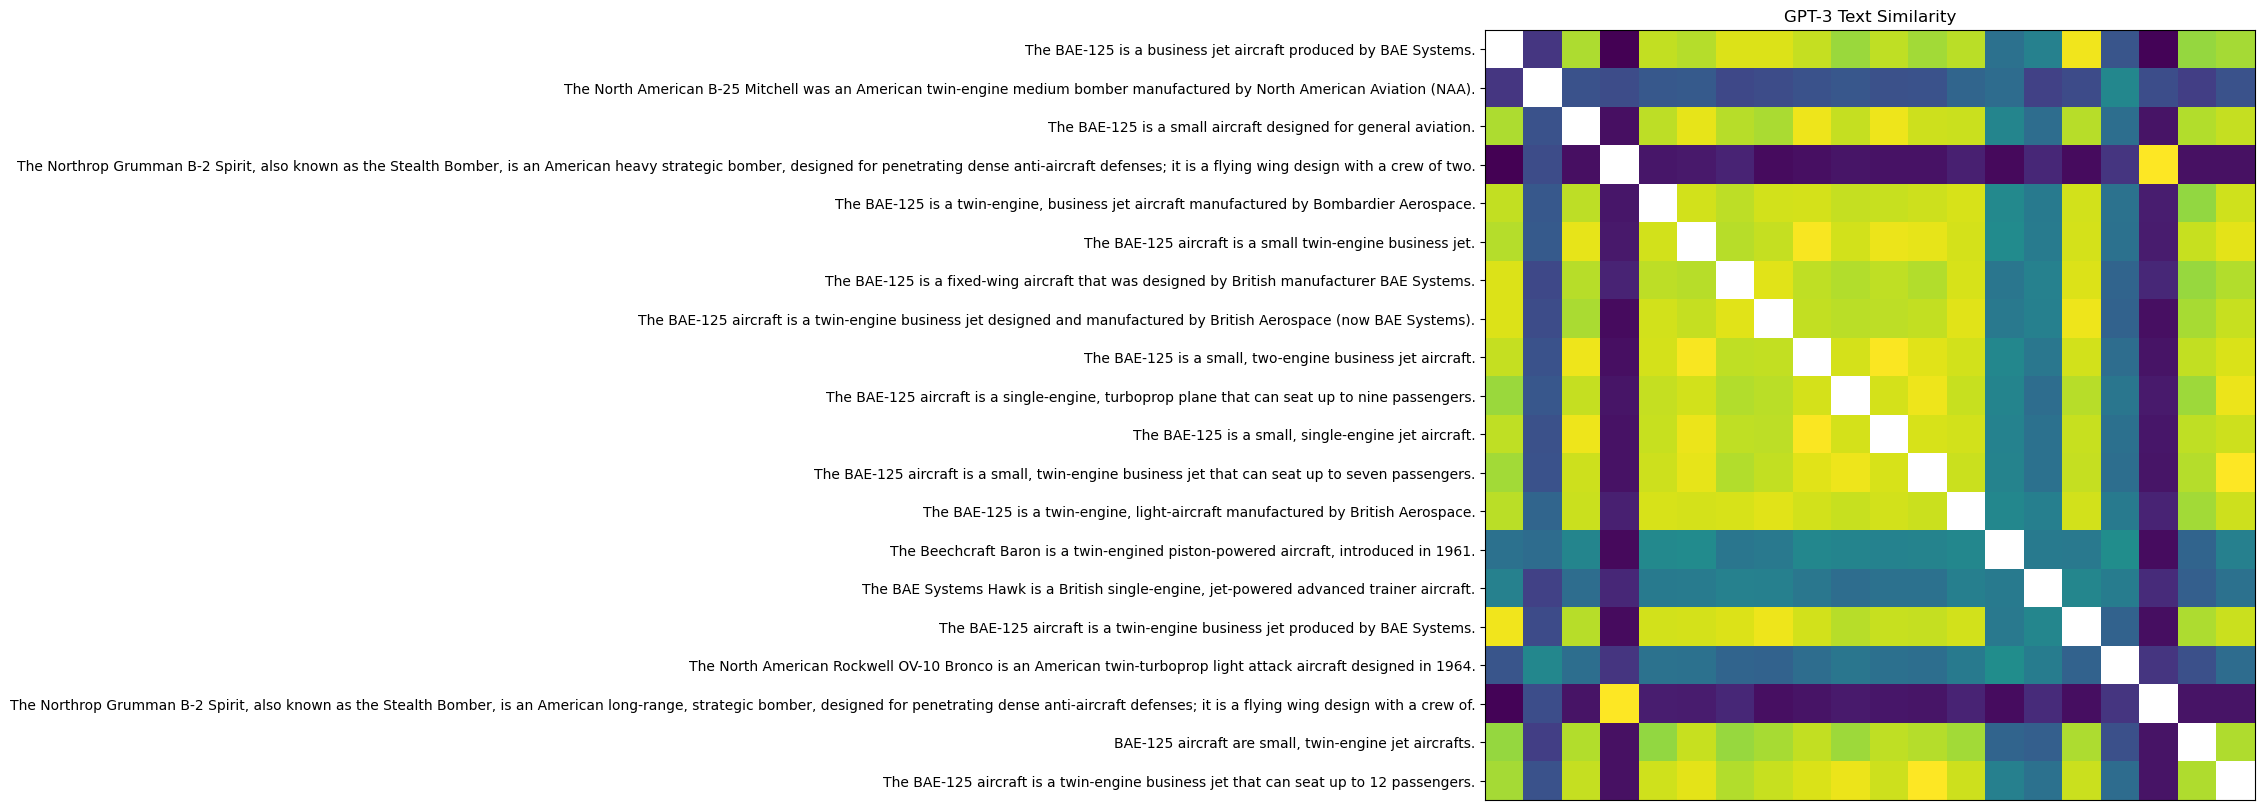

In [18]:
# Visualize dis-similarities of outliers
print(f'Class: ({top_filtered_label_id}){cls_names_sorted[top_filtered_label_id]}')
ylabels = unique_gpt3_prompts[top_filtered_label_id]
for text in outlier_gpt3_prompts[top_filtered_label_id]:
    print(f'({ylabels.index(text)}){text}')
plt.figure(figsize=(12, 10))
plt.imshow(unique_gpt3_text_similarity[top_filtered_label_id])
plt.xticks([])
plt.yticks(np.arange(0, len(ylabels)), ylabels)
plt.title('GPT-3 Text Similarity')
plt.show()

In [19]:
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[label_id] for label_id in range(len(cls_names_sorted))}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 100/100 [00:00<00:00, 193.00it/s]


In [20]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [21]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [22]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [23]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [24]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [25]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 21.00%
Accuracy of CLIP with text template (centroid): 23.88%
Accuracy of CLIP with text template (individual avg): 23.88%
Accuracy of CLIP with original GPT-3 text (centroid): 27.84%
Accuracy of CLIP with original GPT-3 text (individual avg): 27.78%
Accuracy of CLIP with filtered GPT-3 text (centroid): 28.14%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 28.02%
Accuracy of CLIP with combined original GPT-3 text (centroid): 25.83%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 25.14%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 25.59%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 25.05%


In [26]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [27]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=22.12%, std=0.015062161704893414
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=24.92%, std=0.01125631443483546


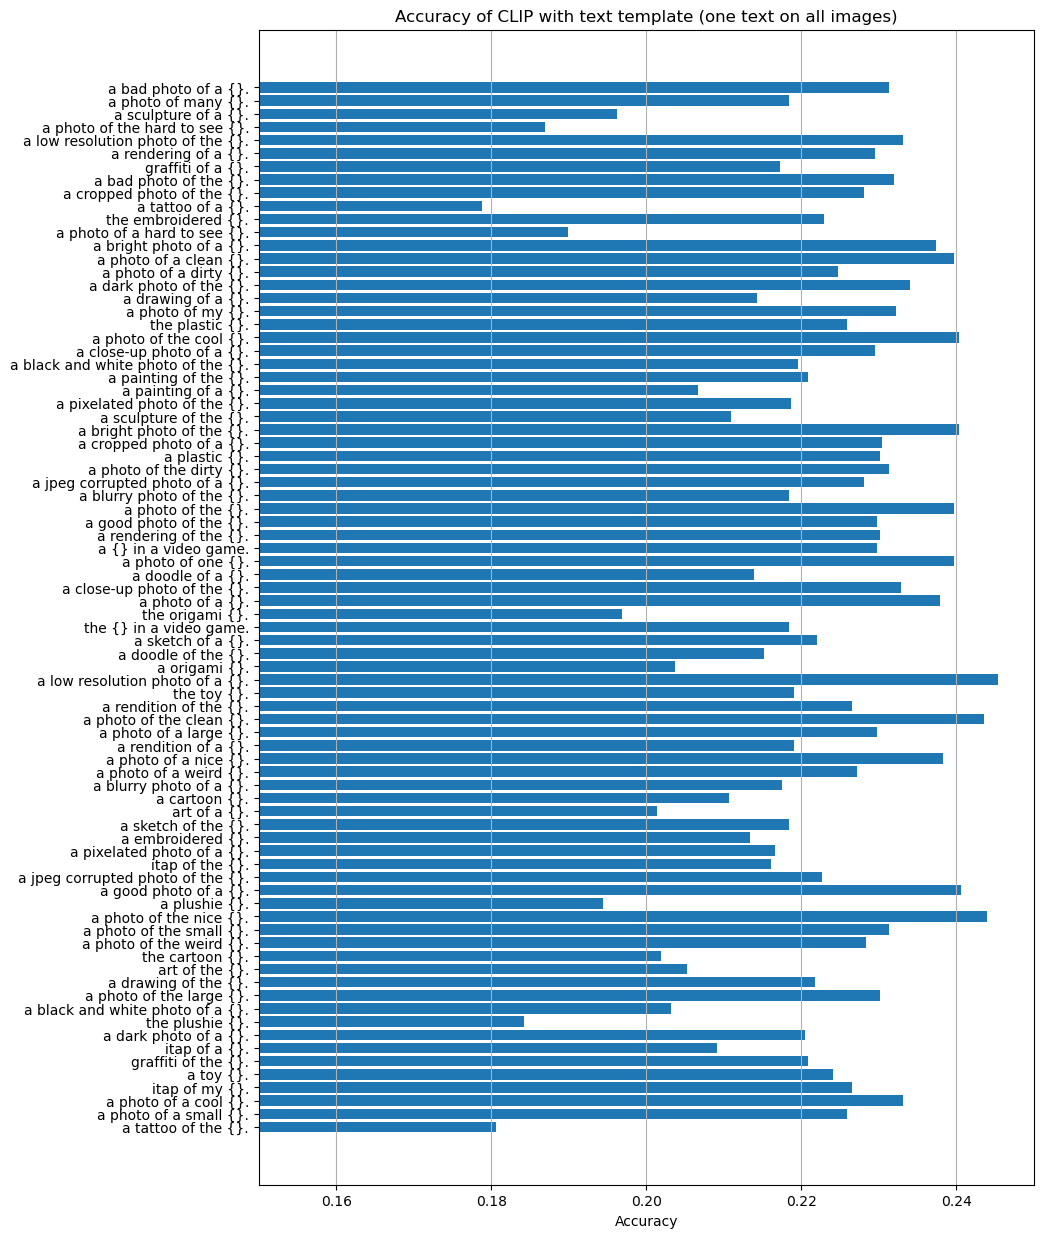

In [28]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [29]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [30]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [31]:
def print_top_pairs(similarity, text, *, top=10, xlabel='', ylabel='', coordinates=None):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        if coordinates is None:
            print(f'Rank {idx+1}: ({label1}){ylabel}{cls_names_sorted[label1]} - ({label2}){xlabel}{cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')
        else:
            print(f'Rank {idx+1}: ({label1}){ylabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label1]} - ({label2}){xlabel}(coor={coordinates[label1][0]:.0f},{coordinates[label1][1]:.0f}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [32]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, similarity.shape[0], 5))
    plt.yticks(np.arange(0, similarity.shape[1], 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [33]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, cm.shape[0], 5))
    plt.yticks(np.arange(0, cm.shape[1], 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [34]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [35]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20, xlabel=f'({xlabel})', ylabel=f'({ylabel})')
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.73974609375
Class name similarity std: 0.09033203125
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (6)737-600 - (7)737-700, similarity: 0.99560546875
Rank 3: (4)737-400 - (6)737-600, similarity: 0.9951171875
Rank 4: (5)737-500 - (6)737-600, similarity: 0.99462890625
Rank 5: (6)737-600 - (8)737-800, similarity: 0.99462890625
Rank 6: (7)737-700 - (8)737-800, similarity: 0.994140625
Rank 7: (5)737-500 - (9)737-900, similarity: 0.994140625
Rank 8: (4)737-400 - (5)737-500, similarity: 0.994140625
Rank 9: (27)A330-200 - (28)A330-300, similarity: 0.99365234375
Rank 10: (3)737-300 - (5)737-500, similarity: 0.99365234375


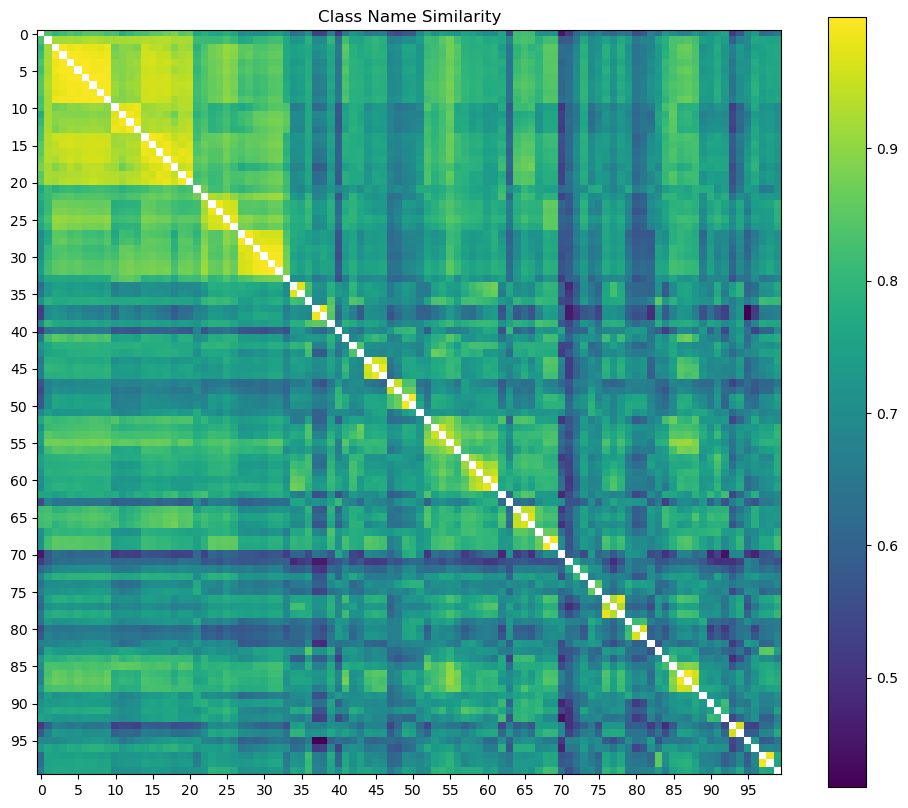

Text template similarity mean: 0.771484375
Text template similarity std: 0.07659912109375
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 3: (6)737-600 - (7)737-700, similarity: 0.99755859375
Rank 4: (19)777-200 - (20)777-300, similarity: 0.99755859375
Rank 5: (8)737-800 - (9)737-900, similarity: 0.99755859375
Rank 6: (7)737-700 - (9)737-900, similarity: 0.9970703125
Rank 7: (6)737-600 - (8)737-800, similarity: 0.9970703125
Rank 8: (16)767-200 - (17)767-300, similarity: 0.9970703125
Rank 9: (6)737-600 - (9)737-900, similarity: 0.9970703125
Rank 10: (27)A330-200 - (28)A330-300, similarity: 0.9970703125


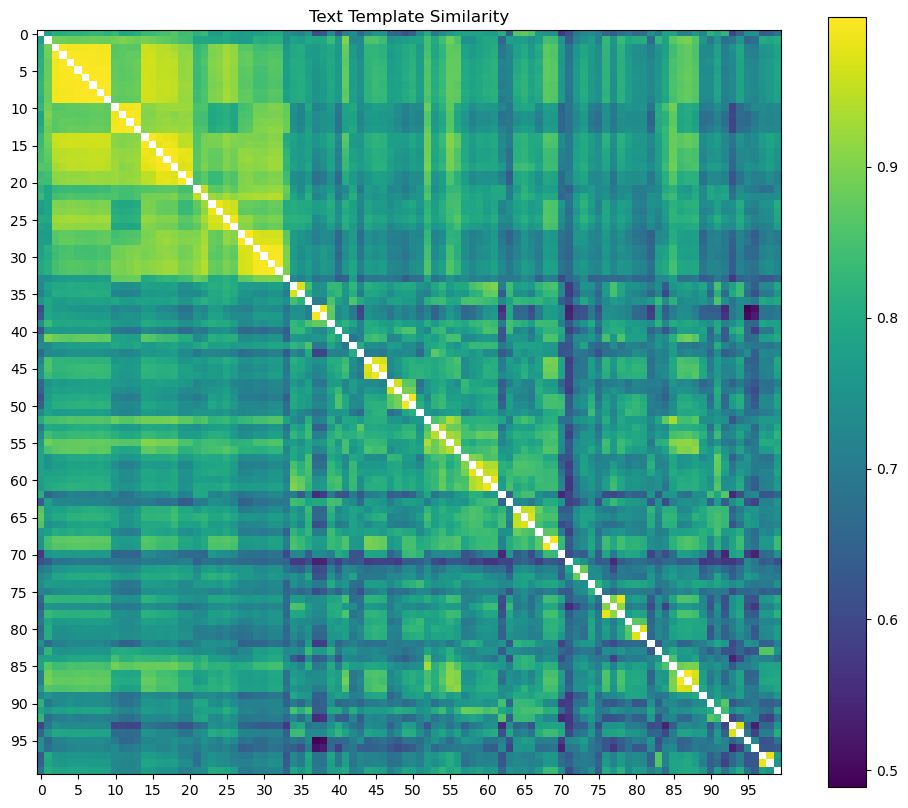

Original gpt-3 text similarity mean: 0.775390625
Original gpt-3 text similarity std: 0.0770263671875
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.99853515625
Rank 2: (6)737-600 - (9)737-900, similarity: 0.998046875
Rank 3: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 4: (27)A330-200 - (28)A330-300, similarity: 0.998046875
Rank 5: (17)767-300 - (18)767-400, similarity: 0.998046875
Rank 6: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 7: (30)A340-300 - (31)A340-500, similarity: 0.9970703125
Rank 8: (29)A340-200 - (30)A340-300, similarity: 0.9970703125
Rank 9: (5)737-500 - (9)737-900, similarity: 0.9970703125
Rank 10: (6)737-600 - (7)737-700, similarity: 0.99658203125


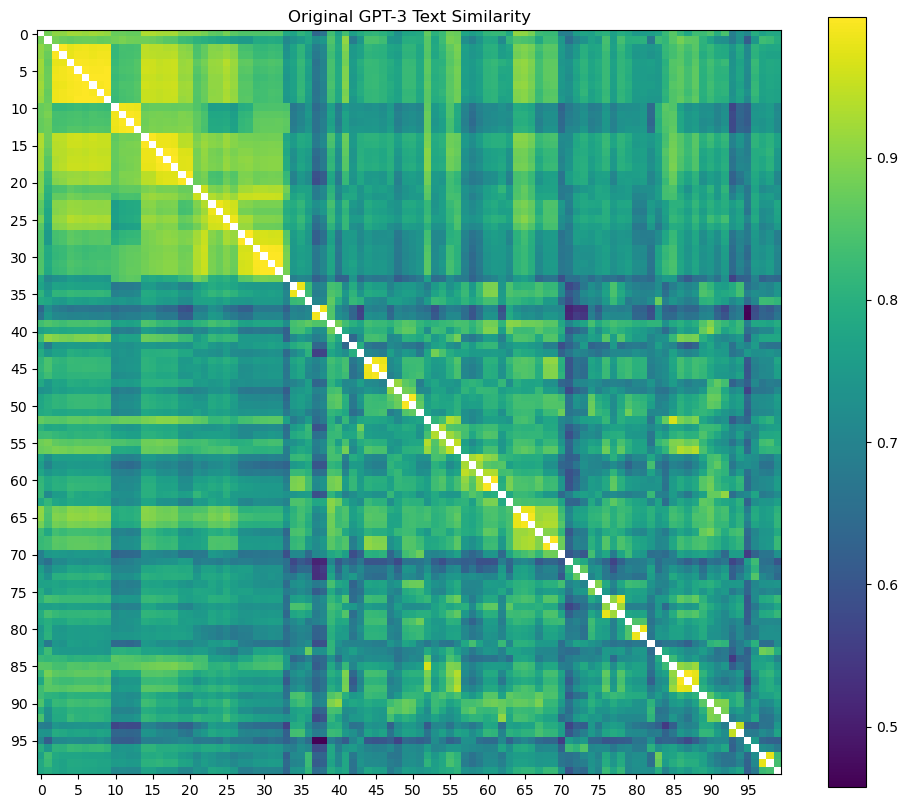

Filtered gpt-3 text similarity mean: 0.775390625
Filtered gpt-3 text similarity std: 0.07672119140625
Rank 1: (31)A340-500 - (32)A340-600, similarity: 0.9990234375
Rank 2: (5)737-500 - (6)737-600, similarity: 0.998046875
Rank 3: (30)A340-300 - (32)A340-600, similarity: 0.99755859375
Rank 4: (17)767-300 - (18)767-400, similarity: 0.99755859375
Rank 5: (27)A330-200 - (28)A330-300, similarity: 0.99755859375
Rank 6: (6)737-600 - (9)737-900, similarity: 0.99755859375
Rank 7: (29)A340-200 - (30)A340-300, similarity: 0.9970703125
Rank 8: (5)737-500 - (9)737-900, similarity: 0.9970703125
Rank 9: (30)A340-300 - (31)A340-500, similarity: 0.9970703125
Rank 10: (4)737-400 - (5)737-500, similarity: 0.99658203125


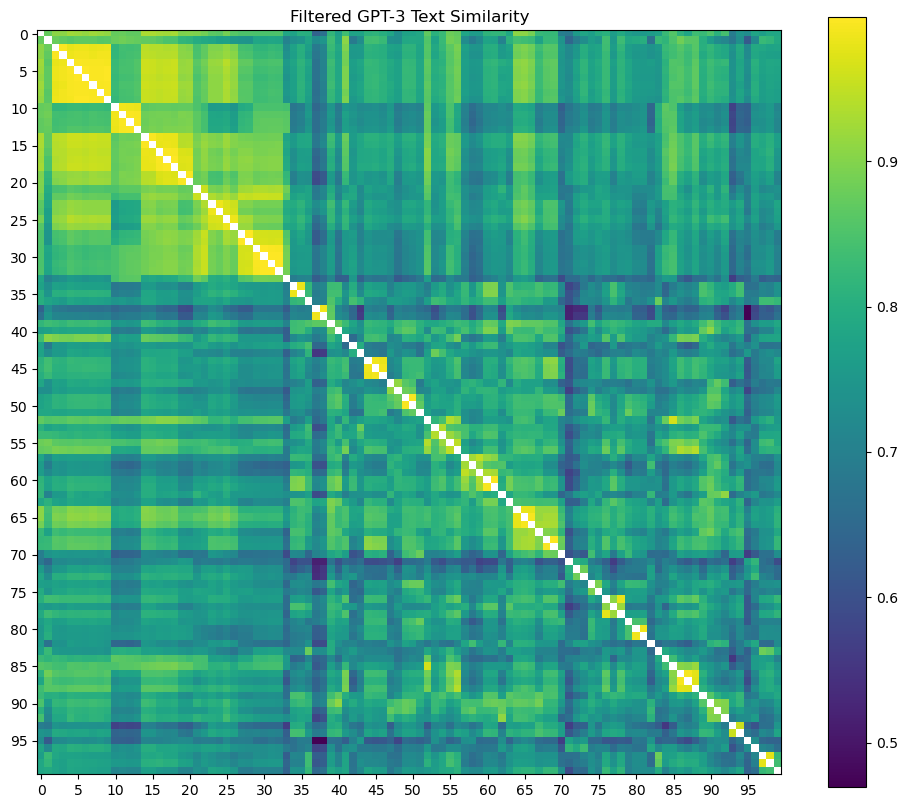

In [36]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.8623046875
Image similarity std: 0.07965087890625
Rank 1: (80)Gulfstream IV - (81)Gulfstream V, similarity: 0.99755859375
Rank 2: (49)Cessna 525 - (50)Cessna 560, similarity: 0.99365234375
Rank 3: (70)Embraer Legacy 600 - (79)Global Express, similarity: 0.99365234375
Rank 4: (3)737-300 - (5)737-500, similarity: 0.99267578125
Rank 5: (39)BAE-125 - (50)Cessna 560, similarity: 0.9921875
Rank 6: (3)737-300 - (4)737-400, similarity: 0.99169921875
Rank 7: (37)BAE 146-200 - (38)BAE 146-300, similarity: 0.99169921875
Rank 8: (51)Challenger 600 - (70)Embraer Legacy 600, similarity: 0.99169921875
Rank 9: (3)737-300 - (8)737-800, similarity: 0.9912109375
Rank 10: (34)ATR-42 - (35)ATR-72, similarity: 0.9912109375


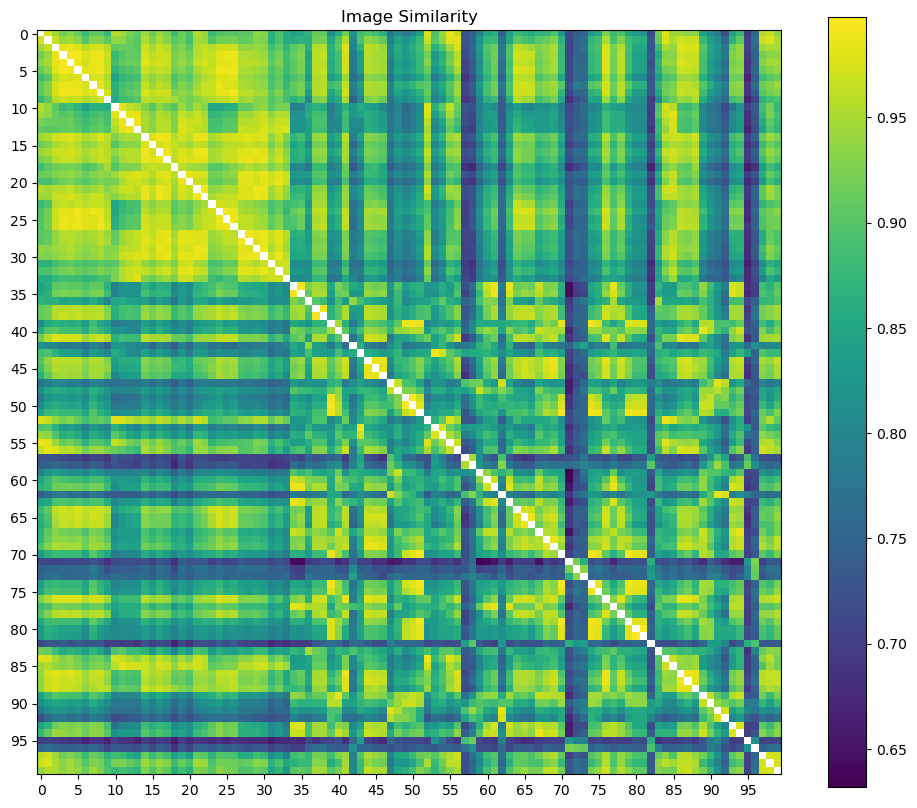

Image to class name similarity mean: 0.2379150390625
Image to class name similarity std: 0.035247802734375
Image to class name similarity diagonal mean: 0.295166015625
Image to class name similarity diagonal std: 0.0189666748046875
Image to class name similarity non-diagonal mean: 0.2374267578125
Image to class name similarity non-diagonal std: 0.034912109375
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.2431640625
Rank 1: (83)(Image)Il-76 - (39)(Text)BAE-125, similarity: 0.326171875
Rank 2: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, similarity: 0.32275390625
Rank 3: (81)(Image)Gulfstream V - (80)(Text)Gulfstream IV, similarity: 0.322021484375
Rank 4: (47)(Image)Cessna 172 - (48)(Text)Cessna 208, similarity: 0.32177734375
Rank 5: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, similarity: 0.32080078125
Rank 6: (75)(Image)Falcon 900 - (74)(Text)Falcon 2000, similarity: 0.3203125
Rank 7: (83)(Image)Il-76 - (37)(Text)BAE 146-200, similarity: 

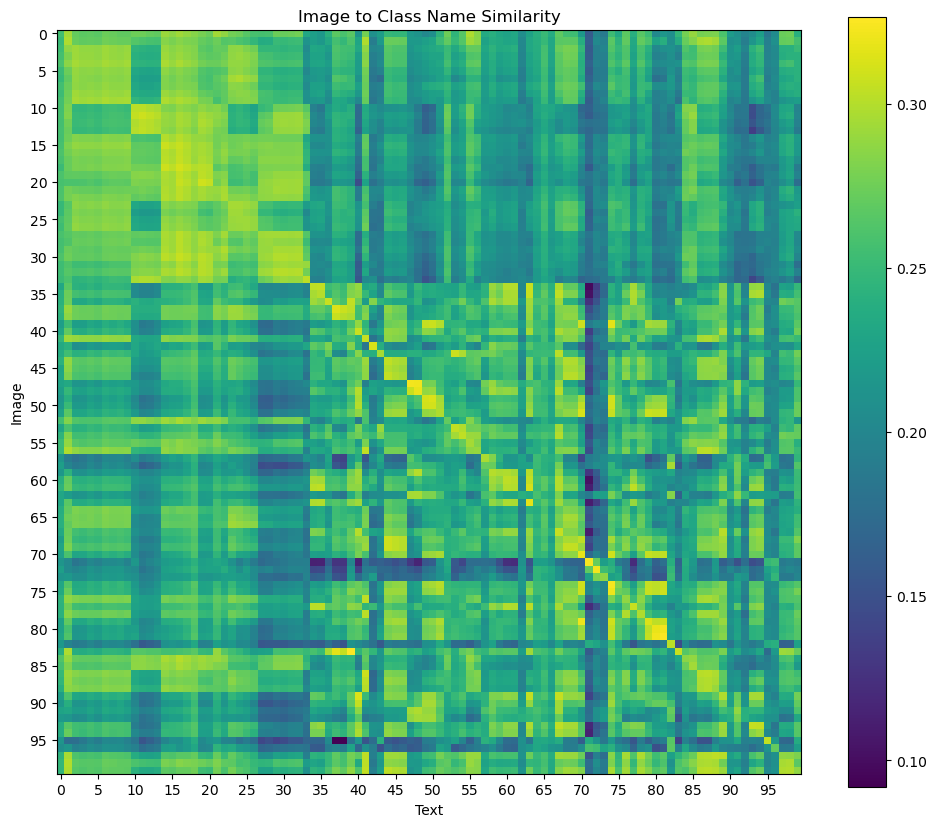

Rank 1: (17)(Image)767-300 - (16)(Text)767-200, error rate: 0.7352941176470589
Rank 2: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, error rate: 0.7352941176470589
Rank 3: (18)(Image)767-400 - (16)(Text)767-200, error rate: 0.696969696969697
Rank 4: (58)(Image)DHC-1 - (82)(Text)Hawk T1, error rate: 0.6666666666666666
Rank 5: (86)(Image)MD-80 - (41)(Text)Boeing 717, error rate: 0.6470588235294118
Rank 6: (75)(Image)Falcon 900 - (74)(Text)Falcon 2000, error rate: 0.6060606060606061
Rank 7: (28)(Image)A330-300 - (16)(Text)767-200, error rate: 0.5757575757575758
Rank 8: (83)(Image)Il-76 - (39)(Text)BAE-125, error rate: 0.5588235294117647
Rank 9: (39)(Image)BAE-125 - (74)(Text)Falcon 2000, error rate: 0.5454545454545454
Rank 10: (14)(Image)757-200 - (16)(Text)767-200, error rate: 0.5294117647058824
Rank 11: (92)(Image)SR-20 - (48)(Text)Cessna 208, error rate: 0.5294117647058824
Rank 12: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, error rate: 0.5151515151515151
Rank 13: (1

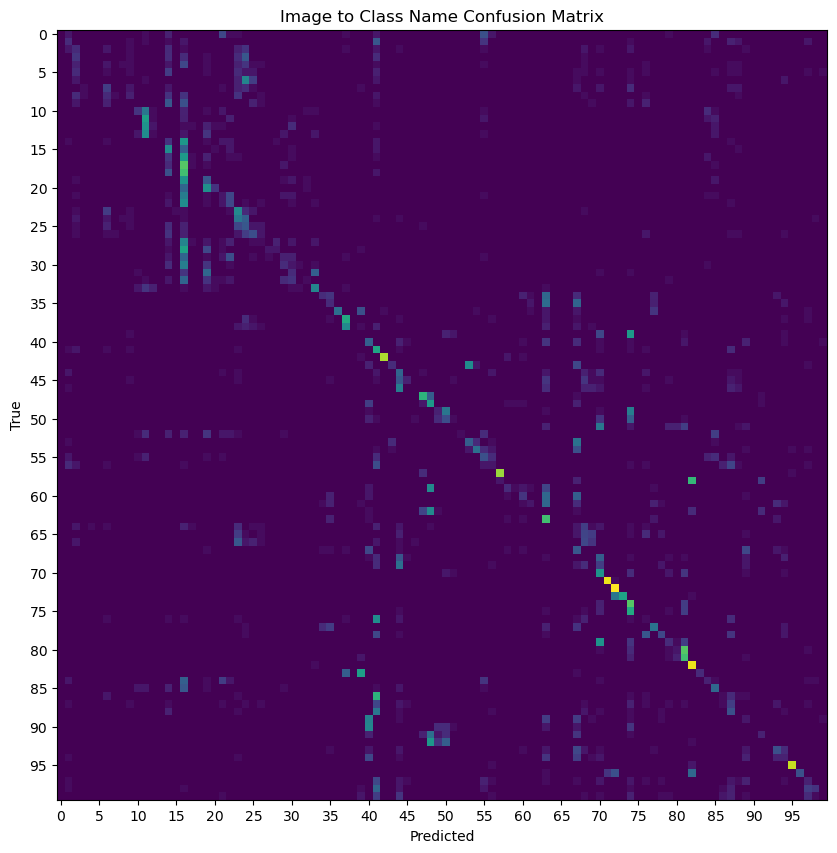

Image to text template (centroid) similarity mean: 0.2509765625
Image to text template (centroid) similarity std: 0.0386962890625
Image to text template (centroid) similarity diagonal mean: 0.315185546875
Image to text template (centroid) similarity diagonal std: 0.0178070068359375
Image to text template (centroid) similarity non-diagonal mean: 0.250244140625
Image to text template (centroid) similarity non-diagonal std: 0.038299560546875
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.259765625
Rank 1: (83)(Image)Il-76 - (39)(Text)BAE-125, similarity: 0.344482421875
Rank 2: (81)(Image)Gulfstream V - (80)(Text)Gulfstream IV, similarity: 0.341796875
Rank 3: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, similarity: 0.33837890625
Rank 4: (83)(Image)Il-76 - (37)(Text)BAE 146-200, similarity: 0.33740234375
Rank 5: (47)(Image)Cessna 172 - (48)(Text)Cessna 208, similarity: 0.337158203125
Rank 6: (37)(Image)BAE 146-200 - (38)(Text)BAE 146-300, simi

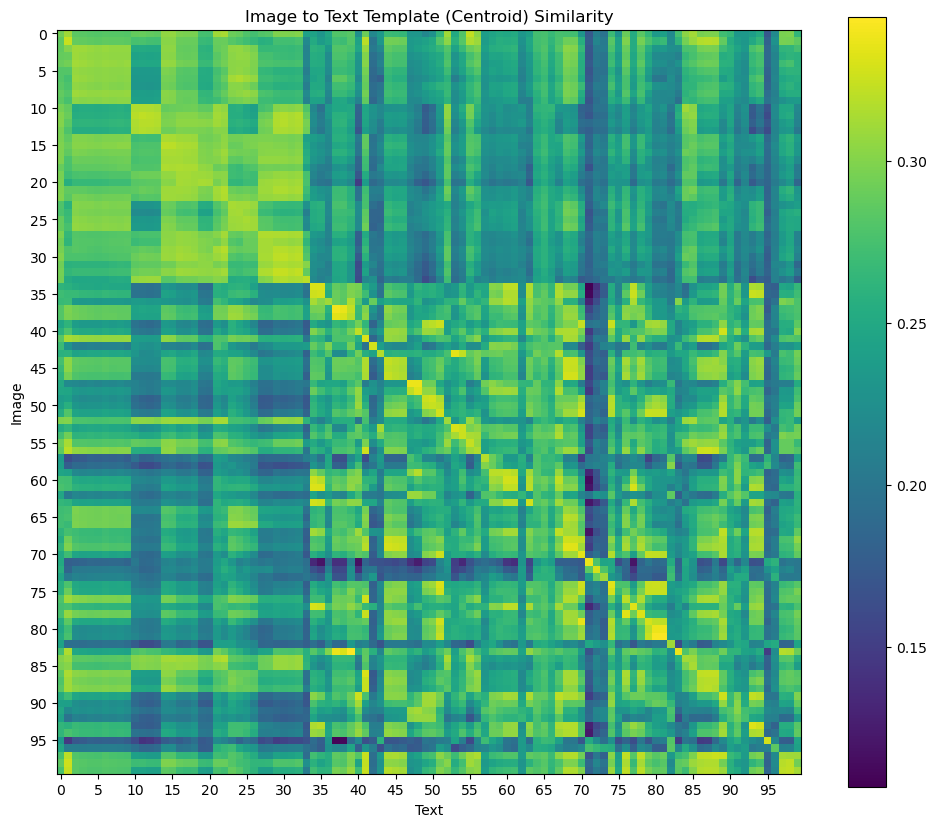

Rank 1: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.696969696969697
Rank 2: (65)(Image)E-190 - (68)(Text)ERJ 135, error rate: 0.6176470588235294
Rank 3: (38)(Image)BAE 146-300 - (37)(Text)BAE 146-200, error rate: 0.5882352941176471
Rank 4: (49)(Image)Cessna 525 - (50)(Text)Cessna 560, error rate: 0.5757575757575758
Rank 5: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, error rate: 0.5588235294117647
Rank 6: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, error rate: 0.5454545454545454
Rank 7: (62)(Image)DR-400 - (47)(Text)Cessna 172, error rate: 0.5294117647058824
Rank 8: (58)(Image)DHC-1 - (82)(Text)Hawk T1, error rate: 0.48484848484848486
Rank 9: (78)(Image)Fokker 70 - (76)(Text)Fokker 100, error rate: 0.45454545454545453
Rank 10: (46)(Image)CRJ-900 - (68)(Text)ERJ 135, error rate: 0.45454545454545453
Rank 11: (92)(Image)SR-20 - (48)(Text)Cessna 208, error rate: 0.4411764705882353
Rank 12: (47)(Image)Cessna 172 - (48)(Text)Cessna 208, error rate: 0.4411764705882353


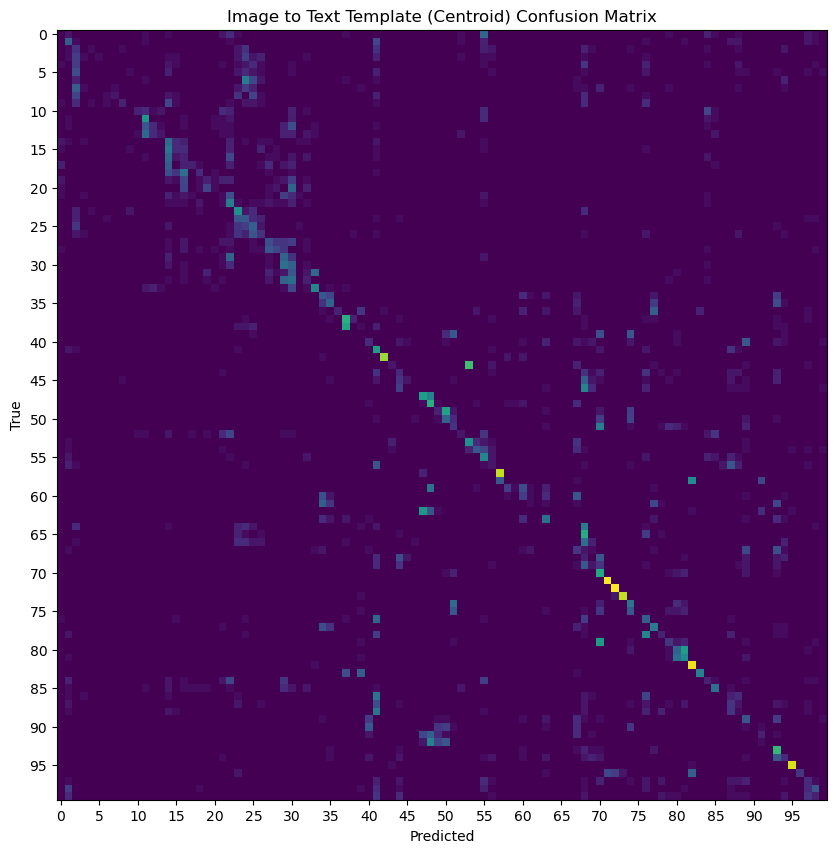

Image to text template (individual avg) similarity mean: 0.22727832198143005
Image to text template (individual avg) similarity std: 0.03500032797455788
Image to text template (individual avg) similarity diagonal mean: 0.2852539122104645
Image to text template (individual avg) similarity diagonal std: 0.01666097342967987
Image to text template (individual avg) similarity non-diagonal mean: 0.22669270634651184
Image to text template (individual avg) similarity non-diagonal std: 0.03464533016085625
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.2583285570144653
Rank 1: (83)(Image)Il-76 - (39)(Text)BAE-125, similarity: 0.3115234375
Rank 2: (81)(Image)Gulfstream V - (80)(Text)Gulfstream IV, similarity: 0.30712890625
Rank 3: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, similarity: 0.30712890625
Rank 4: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, similarity: 0.30712890625
Rank 5: (47)(Image)Cessna 172 - (48)(Text)Cessna 208,

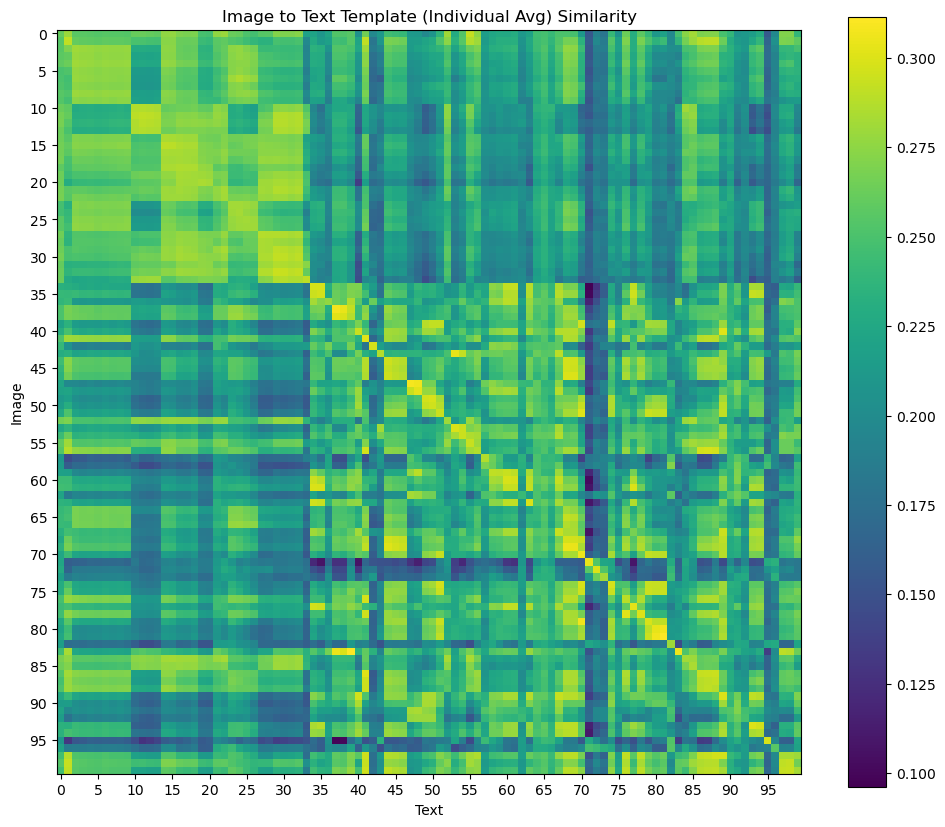

Rank 1: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, error rate: 0.8235294117647058
Rank 2: (62)(Image)DR-400 - (47)(Text)Cessna 172, error rate: 0.6764705882352942
Rank 3: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.6666666666666666
Rank 4: (65)(Image)E-190 - (68)(Text)ERJ 135, error rate: 0.6470588235294118
Rank 5: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, error rate: 0.6363636363636364
Rank 6: (49)(Image)Cessna 525 - (50)(Text)Cessna 560, error rate: 0.6060606060606061
Rank 7: (32)(Image)A340-600 - (29)(Text)A340-200, error rate: 0.5882352941176471
Rank 8: (38)(Image)BAE 146-300 - (37)(Text)BAE 146-200, error rate: 0.5882352941176471
Rank 9: (39)(Image)BAE-125 - (70)(Text)Embraer Legacy 600, error rate: 0.48484848484848486
Rank 10: (30)(Image)A340-300 - (29)(Text)A340-200, error rate: 0.48484848484848486
Rank 11: (15)(Image)757-300 - (14)(Text)757-200, error rate: 0.48484848484848486
Rank 12: (64)(Image)E-170 - (68)(Text)ERJ 135, error rate: 0.4848484848484

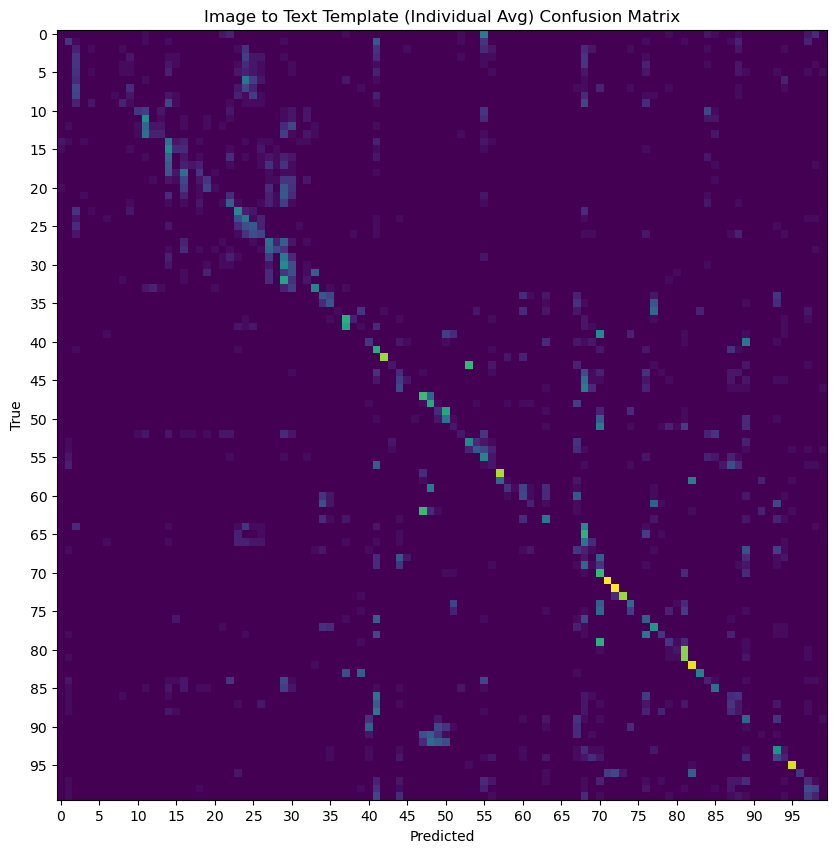

Image to original gpt-3 text (centroid) similarity mean: 0.2430419921875
Image to original gpt-3 text (centroid) similarity std: 0.0413818359375
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.314208984375
Image to original gpt-3 text (centroid) similarity diagonal std: 0.00914764404296875
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.242431640625
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.04095458984375
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.2958984375
Rank 1: (69)(Image)ERJ 145 - (68)(Text)ERJ 135, similarity: 0.331787109375
Rank 2: (68)(Image)ERJ 135 - (44)(Text)CRJ-200, similarity: 0.33154296875
Rank 3: (68)(Image)ERJ 135 - (45)(Text)CRJ-700, similarity: 0.32958984375
Rank 4: (68)(Image)ERJ 135 - (69)(Text)ERJ 145, similarity: 0.32958984375
Rank 5: (69)(Image)ERJ 145 - (44)(Text)CRJ-200, similarity: 0.329345703125
Rank 6: (69)(Image)ERJ 145 - (45)(Text)C

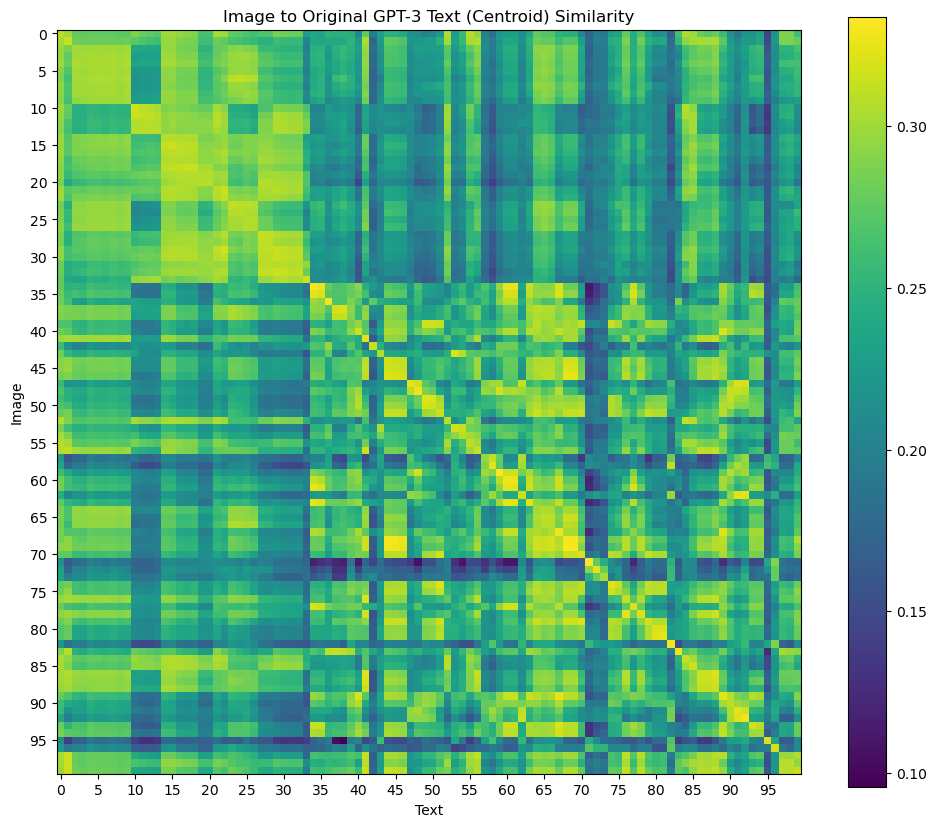

Rank 1: (57)(Image)DH-82 - (58)(Text)DHC-1, error rate: 0.6666666666666666
Rank 2: (62)(Image)DR-400 - (92)(Text)SR-20, error rate: 0.6470588235294118
Rank 3: (32)(Image)A340-600 - (29)(Text)A340-200, error rate: 0.5588235294117647
Rank 4: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.5454545454545454
Rank 5: (50)(Image)Cessna 560 - (49)(Text)Cessna 525, error rate: 0.5294117647058824
Rank 6: (40)(Image)Beechcraft 1900 - (89)(Text)Metroliner, error rate: 0.48484848484848486
Rank 7: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, error rate: 0.4411764705882353
Rank 8: (28)(Image)A330-300 - (27)(Text)A330-200, error rate: 0.42424242424242425
Rank 9: (63)(Image)Dornier 328 - (60)(Text)DHC-8-100, error rate: 0.42424242424242425
Rank 10: (86)(Image)MD-80 - (41)(Text)Boeing 717, error rate: 0.4117647058823529
Rank 11: (76)(Image)Fokker 100 - (41)(Text)Boeing 717, error rate: 0.3939393939393939
Rank 12: (88)(Image)MD-90 - (41)(Text)Boeing 717, error rate: 0.3939393939393939
Rank 13: (77)

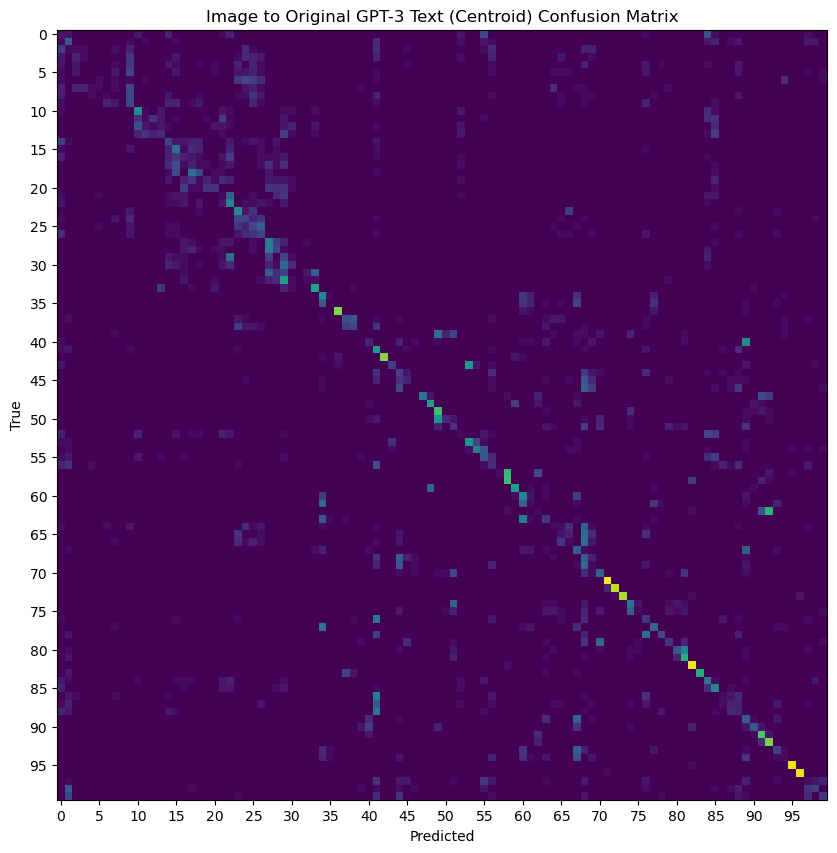

Image to original gpt-3 text (individual avg) similarity mean: 0.2366713136434555
Image to original gpt-3 text (individual avg) similarity std: 0.040498677641153336
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.3060034215450287
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.010845774784684181
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.23597098886966705
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.04008087143301964
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.2967840433120728
Rank 1: (69)(Image)ERJ 145 - (68)(Text)ERJ 135, similarity: 0.3251953125
Rank 2: (68)(Image)ERJ 135 - (44)(Text)CRJ-200, similarity: 0.3232421875
Rank 3: (68)(Image)ERJ 135 - (69)(Text)ERJ 145, similarity: 0.3232421875
Rank 4: (68)(Image)ERJ 135 - (45)(Text)CRJ-700, similarity: 0.322509765625
Rank 5: (86)(Image)MD-80 - (41)(Text)Boeing 717, 

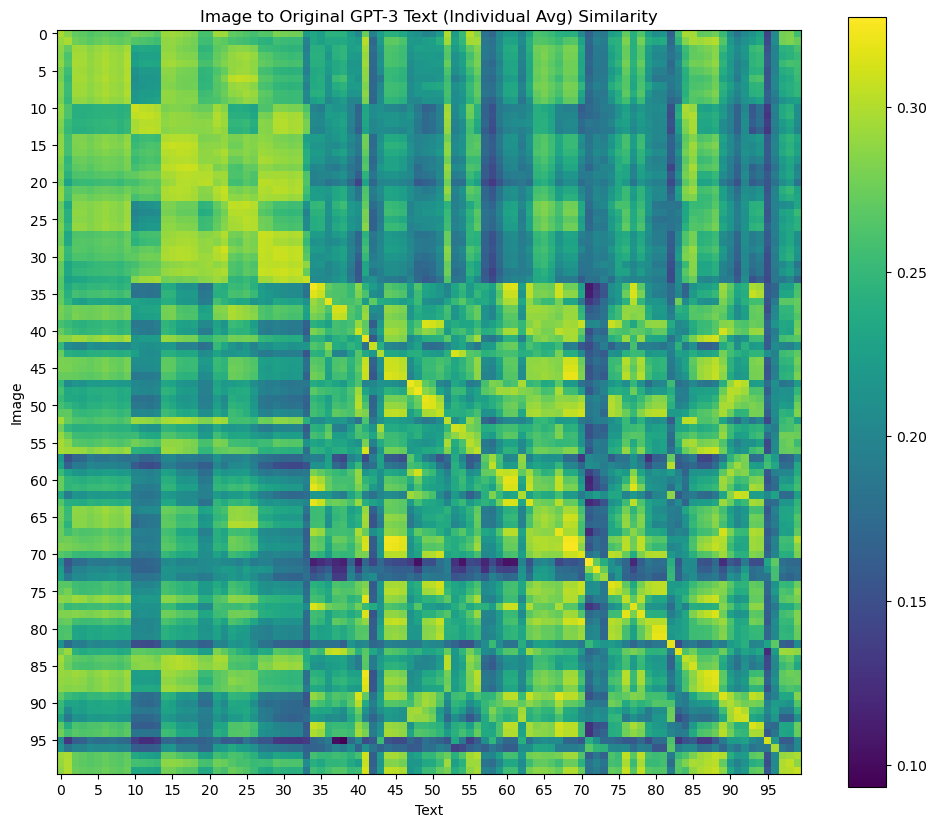

Rank 1: (50)(Image)Cessna 560 - (49)(Text)Cessna 525, error rate: 0.7352941176470589
Rank 2: (28)(Image)A330-300 - (27)(Text)A330-200, error rate: 0.6666666666666666
Rank 3: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.6363636363636364
Rank 4: (62)(Image)DR-400 - (91)(Text)PA-28, error rate: 0.5882352941176471
Rank 5: (18)(Image)767-400 - (17)(Text)767-300, error rate: 0.5757575757575758
Rank 6: (39)(Image)BAE-125 - (49)(Text)Cessna 525, error rate: 0.5454545454545454
Rank 7: (59)(Image)DHC-6 - (48)(Text)Cessna 208, error rate: 0.5
Rank 8: (86)(Image)MD-80 - (41)(Text)Boeing 717, error rate: 0.5
Rank 9: (57)(Image)DH-82 - (58)(Text)DHC-1, error rate: 0.48484848484848486
Rank 10: (76)(Image)Fokker 100 - (41)(Text)Boeing 717, error rate: 0.48484848484848486
Rank 11: (66)(Image)E-195 - (68)(Text)ERJ 135, error rate: 0.48484848484848486
Rank 12: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, error rate: 0.45454545454545453
Rank 13: (65)(Image)E-190 - (68)(Text)ERJ 135, error 

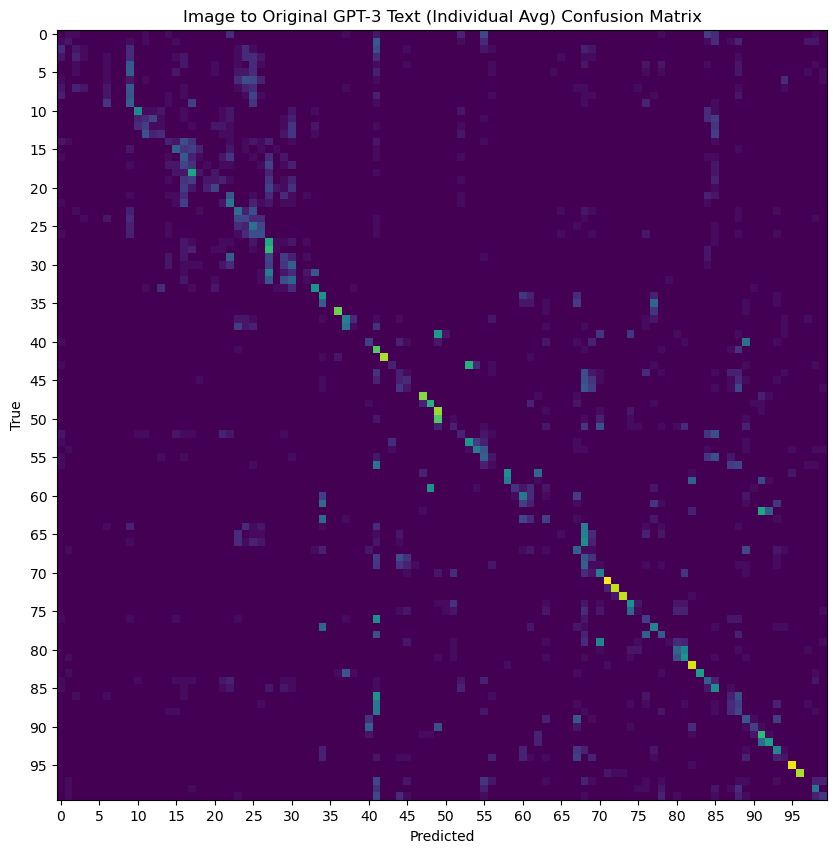

Image to filtered gpt-3 text (centroid) similarity mean: 0.2432861328125
Image to filtered gpt-3 text (centroid) similarity std: 0.041351318359375
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.314453125
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.00905609130859375
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.242431640625
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.04095458984375
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.296875
Rank 1: (69)(Image)ERJ 145 - (68)(Text)ERJ 135, similarity: 0.33154296875
Rank 2: (68)(Image)ERJ 135 - (44)(Text)CRJ-200, similarity: 0.33154296875
Rank 3: (68)(Image)ERJ 135 - (45)(Text)CRJ-700, similarity: 0.329833984375
Rank 4: (68)(Image)ERJ 135 - (69)(Text)ERJ 145, similarity: 0.32958984375
Rank 5: (69)(Image)ERJ 145 - (44)(Text)CRJ-200, similarity: 0.329345703125
Rank 6: (34)(Image)ATR-42 - (35)(Text)ATR-72,

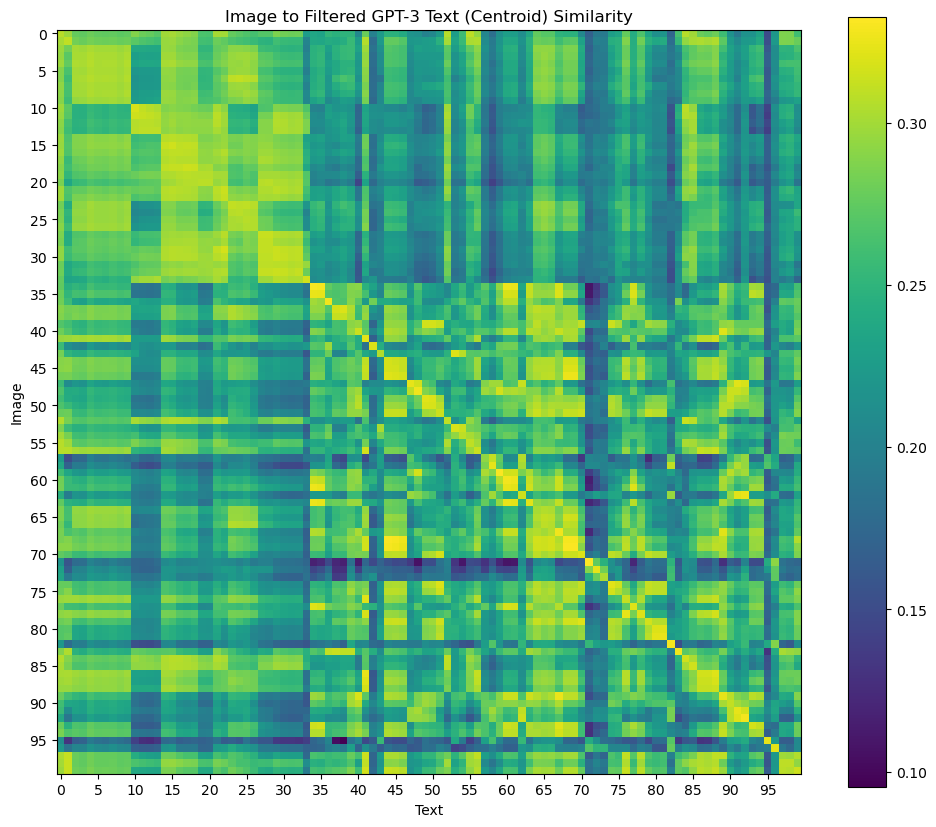

Rank 1: (62)(Image)DR-400 - (92)(Text)SR-20, error rate: 0.6764705882352942
Rank 2: (57)(Image)DH-82 - (58)(Text)DHC-1, error rate: 0.6363636363636364
Rank 3: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.6060606060606061
Rank 4: (32)(Image)A340-600 - (29)(Text)A340-200, error rate: 0.5588235294117647
Rank 5: (28)(Image)A330-300 - (27)(Text)A330-200, error rate: 0.5151515151515151
Rank 6: (50)(Image)Cessna 560 - (49)(Text)Cessna 525, error rate: 0.5
Rank 7: (86)(Image)MD-80 - (41)(Text)Boeing 717, error rate: 0.5
Rank 8: (40)(Image)Beechcraft 1900 - (89)(Text)Metroliner, error rate: 0.48484848484848486
Rank 9: (63)(Image)Dornier 328 - (60)(Text)DHC-8-100, error rate: 0.42424242424242425
Rank 10: (76)(Image)Fokker 100 - (41)(Text)Boeing 717, error rate: 0.42424242424242425
Rank 11: (80)(Image)Gulfstream IV - (81)(Text)Gulfstream V, error rate: 0.4117647058823529
Rank 12: (88)(Image)MD-90 - (41)(Text)Boeing 717, error rate: 0.3939393939393939
Rank 13: (78)(Image)Fokker 70 - (76)(Text)F

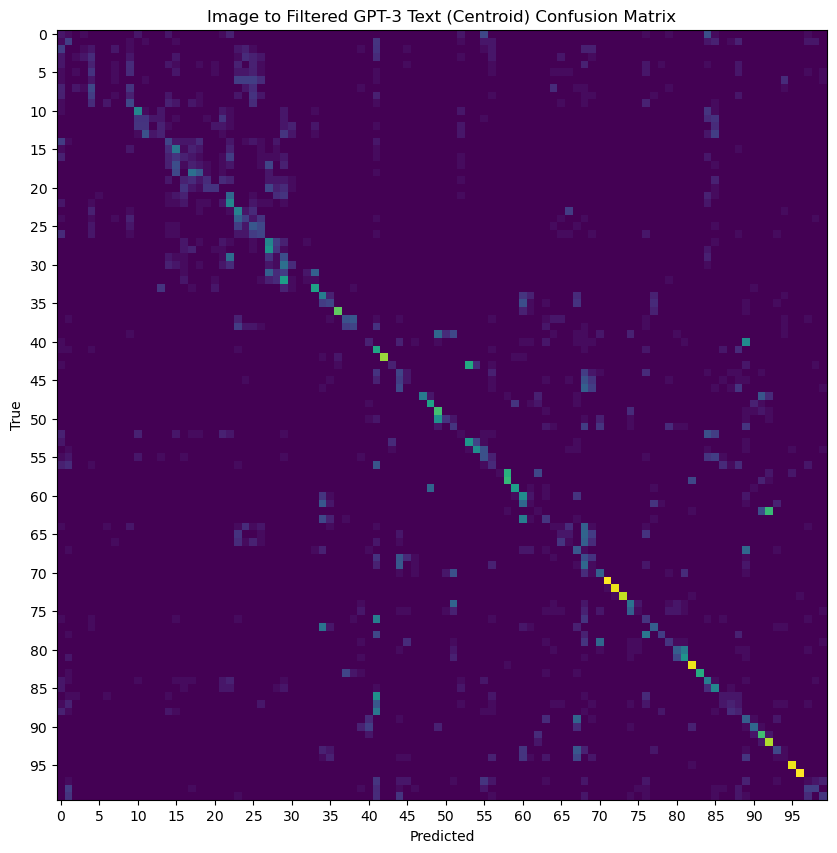

Image to filtered gpt-3 text (individual avg) similarity mean: 0.23708713054656982
Image to filtered gpt-3 text (individual avg) similarity std: 0.04047094285488129
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.30656492710113525
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.010187758132815361
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.23638533055782318
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.04005173221230507
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.2968864440917969
Rank 1: (69)(Image)ERJ 145 - (68)(Text)ERJ 135, similarity: 0.324951171875
Rank 2: (68)(Image)ERJ 135 - (44)(Text)CRJ-200, similarity: 0.3232421875
Rank 3: (68)(Image)ERJ 135 - (69)(Text)ERJ 145, similarity: 0.322998046875
Rank 4: (34)(Image)ATR-42 - (35)(Text)ATR-72, similarity: 0.32275390625
Rank 5: (68)(Image)ERJ 135 - (45)(Text)CRJ-700,

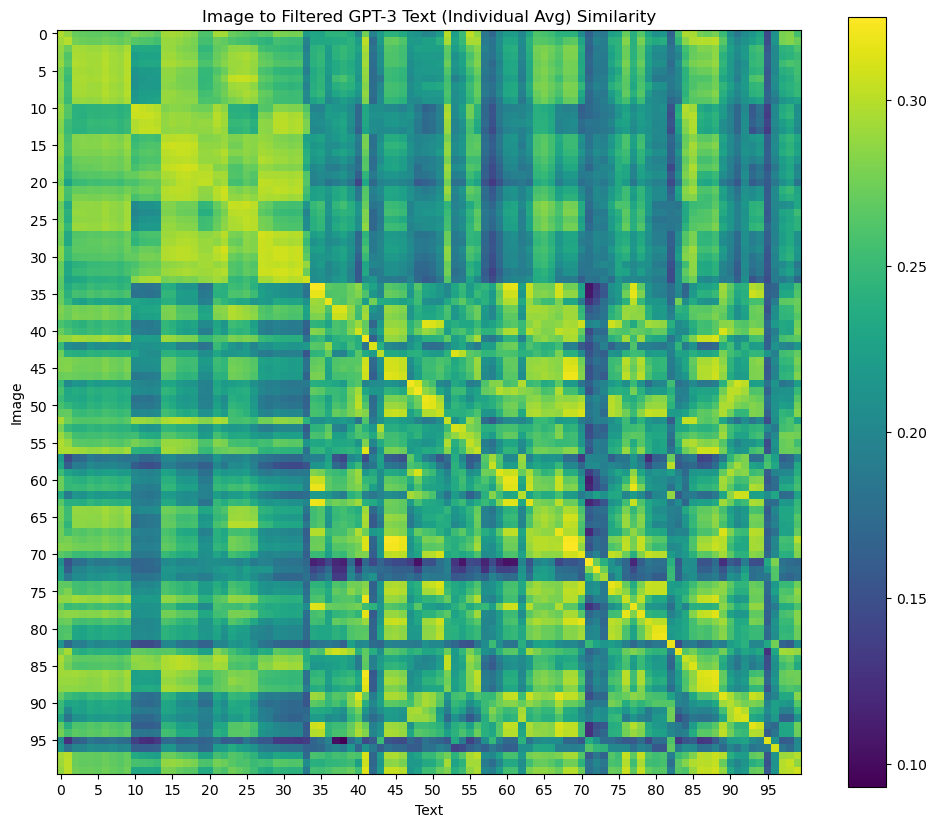

Rank 1: (50)(Image)Cessna 560 - (49)(Text)Cessna 525, error rate: 0.7352941176470589
Rank 2: (18)(Image)767-400 - (17)(Text)767-300, error rate: 0.6363636363636364
Rank 3: (28)(Image)A330-300 - (27)(Text)A330-200, error rate: 0.6363636363636364
Rank 4: (43)(Image)C-47 - (53)(Text)DC-3, error rate: 0.6060606060606061
Rank 5: (86)(Image)MD-80 - (41)(Text)Boeing 717, error rate: 0.5882352941176471
Rank 6: (62)(Image)DR-400 - (91)(Text)PA-28, error rate: 0.5588235294117647
Rank 7: (39)(Image)BAE-125 - (49)(Text)Cessna 525, error rate: 0.5151515151515151
Rank 8: (76)(Image)Fokker 100 - (41)(Text)Boeing 717, error rate: 0.5151515151515151
Rank 9: (59)(Image)DHC-6 - (48)(Text)Cessna 208, error rate: 0.5
Rank 10: (57)(Image)DH-82 - (58)(Text)DHC-1, error rate: 0.48484848484848486
Rank 11: (79)(Image)Global Express - (70)(Text)Embraer Legacy 600, error rate: 0.45454545454545453
Rank 12: (66)(Image)E-195 - (68)(Text)ERJ 135, error rate: 0.45454545454545453
Rank 13: (88)(Image)MD-90 - (41)(Text)B

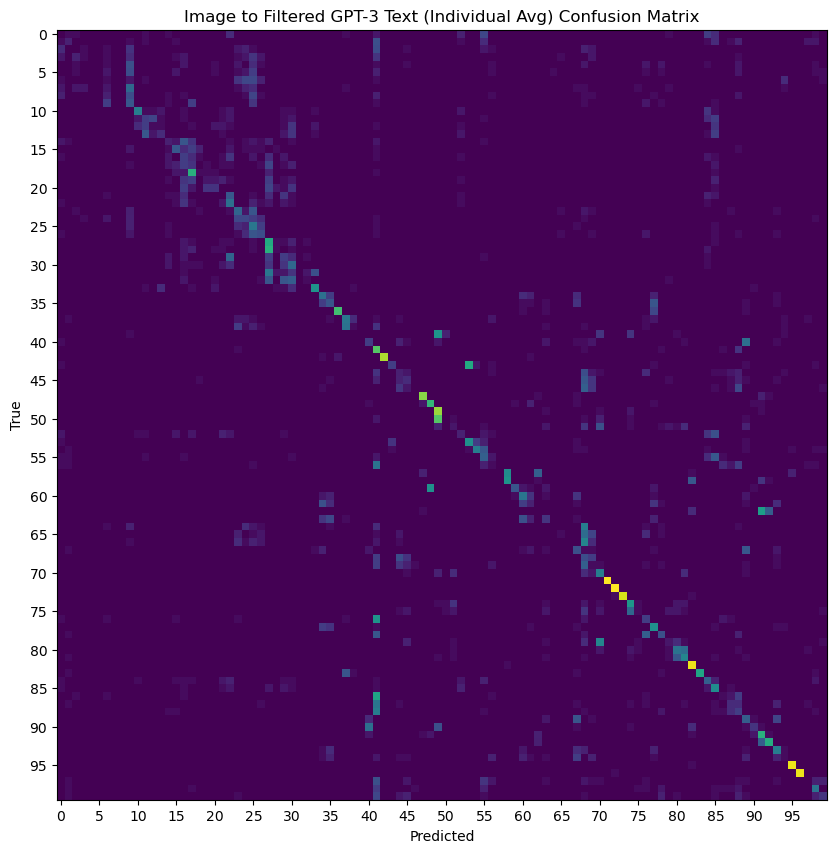

In [37]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [38]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [39]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [40]:
def calc_centroid(features, label_ids):
    return [features[label_ids == label_id].mean(axis=0) for label_id in range(len(cls_names_sorted))]

In [41]:
cls_name_transformed_features = transformed_features[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_label_ids = all_label_ids[cls_name_start_idx:cls_name_end_idx]
cls_name_transformed_centroids = calc_centroid(cls_name_transformed_features, cls_name_transformed_label_ids)
template_transformed_features = transformed_features[template_start_idx:template_end_idx]
template_transformed_label_ids = all_label_ids[template_start_idx:template_end_idx]
template_transformed_centroids = calc_centroid(template_transformed_features, template_transformed_label_ids)
original_gpt3_transformed_features = transformed_features[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_label_ids = all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx]
original_gpt3_transformed_centroids = calc_centroid(original_gpt3_transformed_features, original_gpt3_transformed_label_ids)
filtered_gpt3_transformed_features = transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_label_ids = all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx]
filtered_gpt3_transformed_centroids = calc_centroid(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids)

In [42]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.title(title)
    plt.show()

Rank 1: (31)(coor=50,4)A340-500 - (32)(coor=50,4)A340-600, similarity: 0.9990234375
Rank 2: (6)(coor=25,27)737-600 - (7)(coor=25,27)737-700, similarity: 0.99560546875
Rank 3: (4)(coor=25,27)737-400 - (6)(coor=25,27)737-600, similarity: 0.9951171875
Rank 4: (5)(coor=25,27)737-500 - (6)(coor=25,27)737-600, similarity: 0.99462890625
Rank 5: (6)(coor=25,27)737-600 - (8)(coor=25,27)737-800, similarity: 0.99462890625
Rank 6: (7)(coor=25,28)737-700 - (8)(coor=25,28)737-800, similarity: 0.994140625
Rank 7: (5)(coor=25,27)737-500 - (9)(coor=25,27)737-900, similarity: 0.994140625
Rank 8: (4)(coor=25,27)737-400 - (5)(coor=25,27)737-500, similarity: 0.994140625
Rank 9: (27)(coor=50,4)A330-200 - (28)(coor=50,4)A330-300, similarity: 0.99365234375
Rank 10: (3)(coor=25,27)737-300 - (5)(coor=25,27)737-500, similarity: 0.99365234375


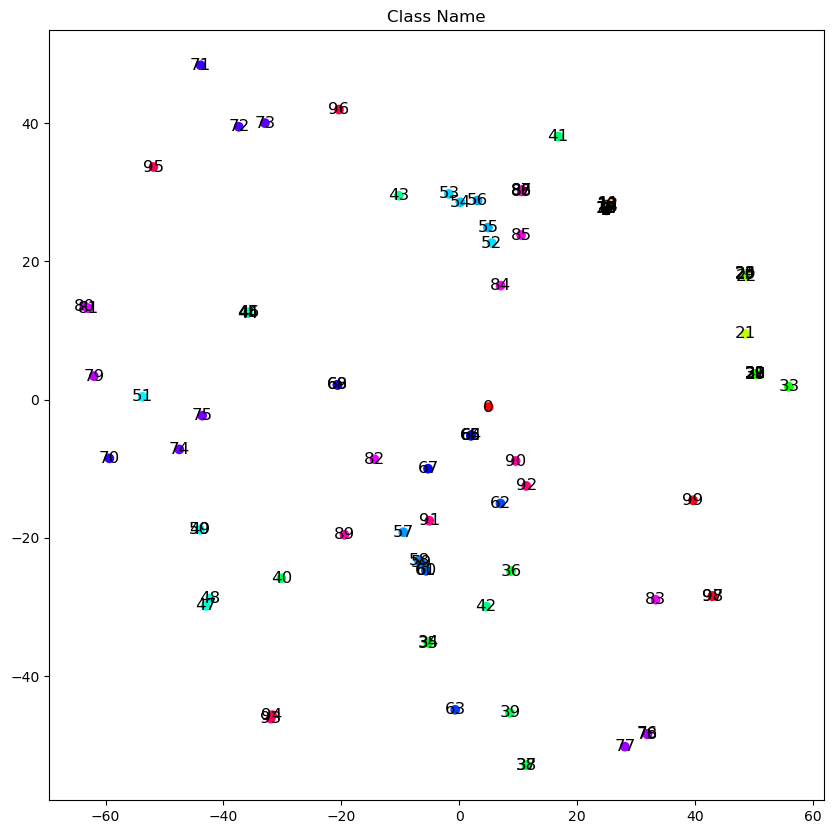

Rank 1: (31)(coor=26,-1)A340-500 - (32)(coor=26,-1)A340-600, similarity: 0.9990234375
Rank 2: (5)(coor=19,6)737-500 - (6)(coor=19,6)737-600, similarity: 0.998046875
Rank 3: (6)(coor=19,6)737-600 - (7)(coor=19,6)737-700, similarity: 0.99755859375
Rank 4: (19)(coor=19,4)777-200 - (20)(coor=19,4)777-300, similarity: 0.99755859375
Rank 5: (8)(coor=19,6)737-800 - (9)(coor=19,6)737-900, similarity: 0.99755859375
Rank 6: (7)(coor=19,6)737-700 - (9)(coor=19,6)737-900, similarity: 0.9970703125
Rank 7: (6)(coor=19,6)737-600 - (8)(coor=19,6)737-800, similarity: 0.9970703125
Rank 8: (16)(coor=19,5)767-200 - (17)(coor=19,5)767-300, similarity: 0.9970703125
Rank 9: (6)(coor=19,6)737-600 - (9)(coor=19,6)737-900, similarity: 0.9970703125
Rank 10: (27)(coor=26,-1)A330-200 - (28)(coor=26,-1)A330-300, similarity: 0.9970703125


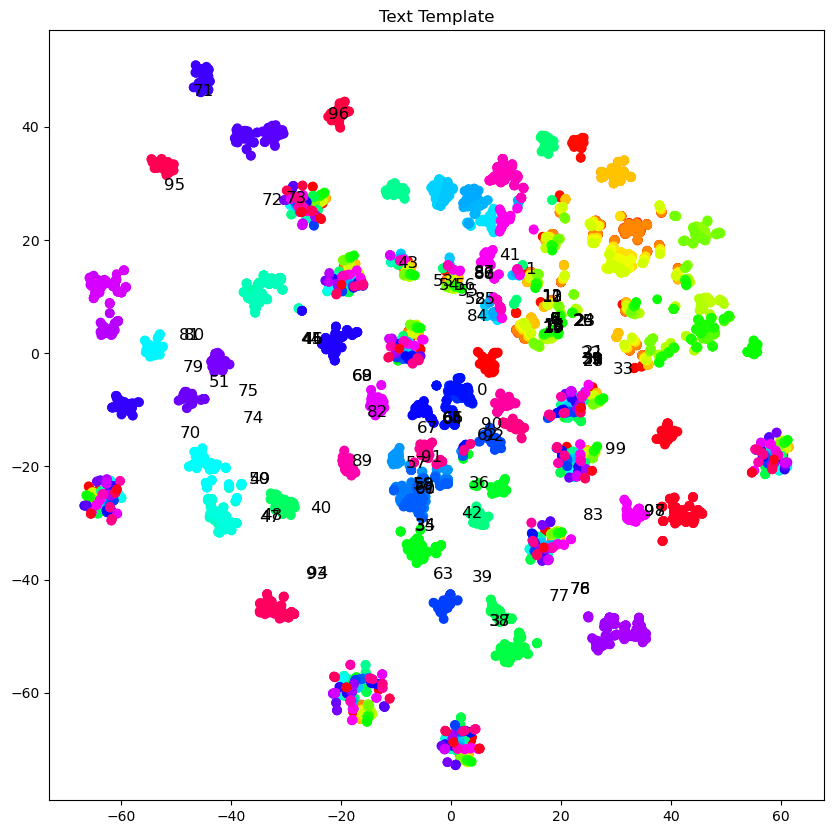

Rank 1: (31)(coor=67,5)A340-500 - (32)(coor=67,5)A340-600, similarity: 0.99853515625
Rank 2: (6)(coor=-20,60)737-600 - (9)(coor=-20,60)737-900, similarity: 0.998046875
Rank 3: (5)(coor=-19,57)737-500 - (6)(coor=-19,57)737-600, similarity: 0.998046875
Rank 4: (27)(coor=72,9)A330-200 - (28)(coor=72,9)A330-300, similarity: 0.998046875
Rank 5: (17)(coor=-2,63)767-300 - (18)(coor=-2,63)767-400, similarity: 0.998046875
Rank 6: (30)(coor=67,4)A340-300 - (32)(coor=67,4)A340-600, similarity: 0.99755859375
Rank 7: (30)(coor=67,4)A340-300 - (31)(coor=67,4)A340-500, similarity: 0.9970703125
Rank 8: (29)(coor=67,4)A340-200 - (30)(coor=67,4)A340-300, similarity: 0.9970703125
Rank 9: (5)(coor=-19,57)737-500 - (9)(coor=-19,57)737-900, similarity: 0.9970703125
Rank 10: (6)(coor=-20,60)737-600 - (7)(coor=-20,60)737-700, similarity: 0.99658203125


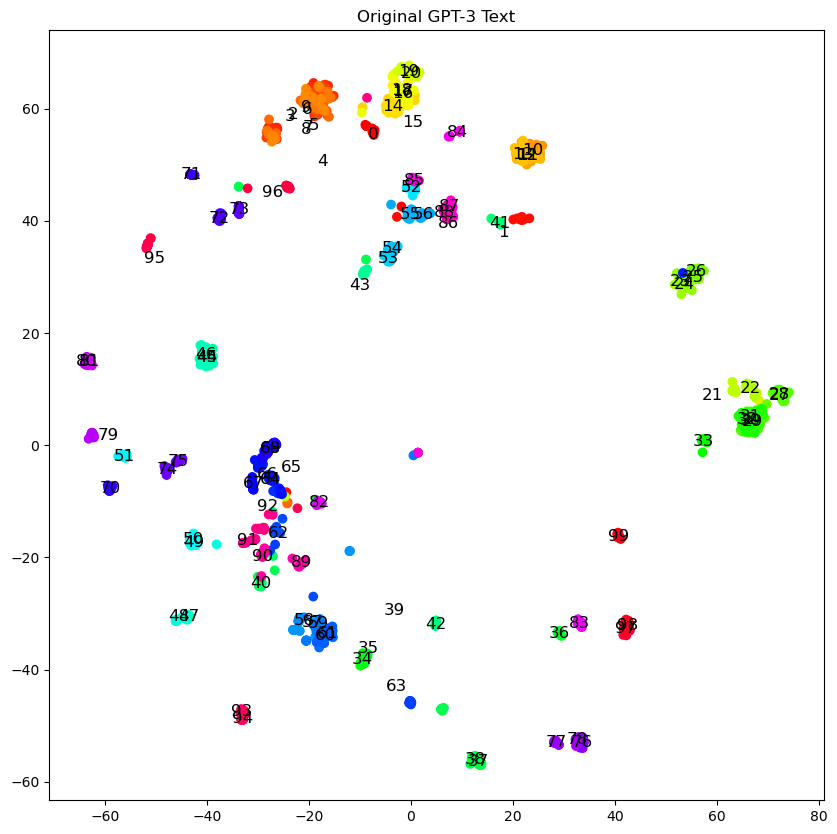

Rank 1: (31)(coor=67,5)A340-500 - (32)(coor=67,5)A340-600, similarity: 0.9990234375
Rank 2: (5)(coor=-19,57)737-500 - (6)(coor=-19,57)737-600, similarity: 0.998046875
Rank 3: (30)(coor=67,4)A340-300 - (32)(coor=67,4)A340-600, similarity: 0.99755859375
Rank 4: (17)(coor=-2,63)767-300 - (18)(coor=-2,63)767-400, similarity: 0.99755859375
Rank 5: (27)(coor=72,9)A330-200 - (28)(coor=72,9)A330-300, similarity: 0.99755859375
Rank 6: (6)(coor=-20,60)737-600 - (9)(coor=-20,60)737-900, similarity: 0.99755859375
Rank 7: (29)(coor=67,4)A340-200 - (30)(coor=67,4)A340-300, similarity: 0.9970703125
Rank 8: (5)(coor=-19,57)737-500 - (9)(coor=-19,57)737-900, similarity: 0.9970703125
Rank 9: (30)(coor=67,4)A340-300 - (31)(coor=67,4)A340-500, similarity: 0.9970703125
Rank 10: (4)(coor=-18,52)737-400 - (5)(coor=-18,52)737-500, similarity: 0.99658203125


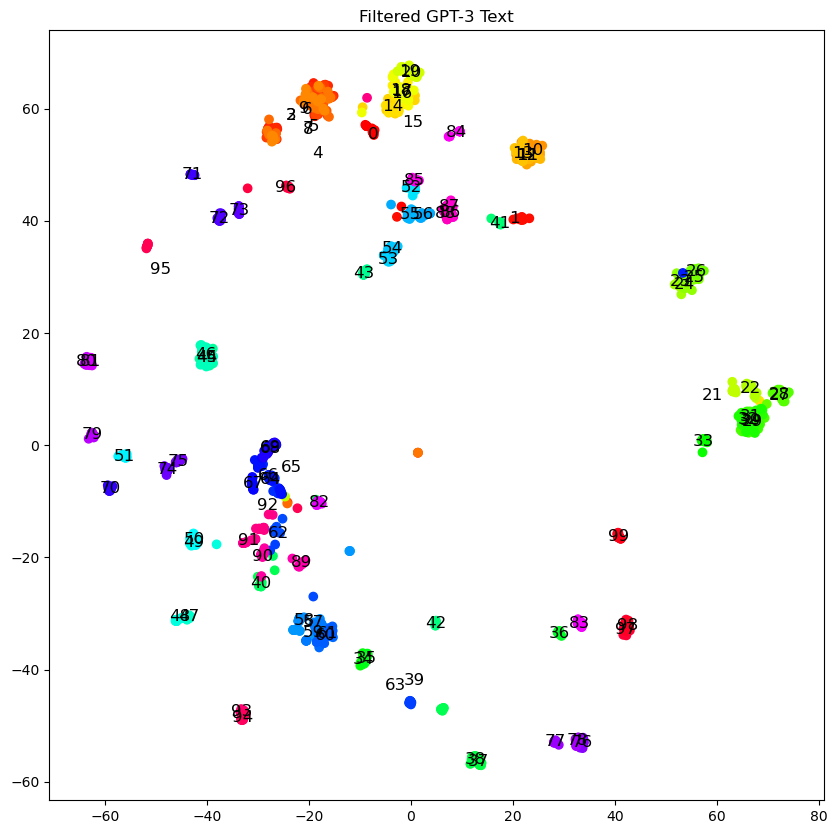

In [43]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity', coordinates=cls_name_transformed_centroids)
plot_features_2d(cls_name_transformed_features, cls_name_transformed_label_ids, 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity', coordinates=template_transformed_centroids)
plot_features_2d(template_transformed_features, template_transformed_label_ids, 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity', coordinates=original_gpt3_transformed_centroids)
plot_features_2d(original_gpt3_transformed_features, original_gpt3_transformed_label_ids, 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity', coordinates=filtered_gpt3_transformed_centroids)
plot_features_2d(filtered_gpt3_transformed_features, filtered_gpt3_transformed_label_ids, 'Filtered GPT-3 Text')